<a href="https://colab.research.google.com/github/emely3h/Geospatial_ML/blob/feature%2Fadd-data-generators-to-fix-ram-problem/notebooks/experiment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-Net Experiment 3: Training an U-Net on the entire dataset

The goal of this notebook is to evaluate whether tile-overlapping has an effect on the resulting model.
We will use the exact same setup as in experiment 1 except for the dataset. Each tile has a size of (256, 256) and the step size is 256 to exclude overlap.

All previous experiments have only been used on a small part of the entire dataset. In this experiment all 16 images of
the entire dataset will be split into tiles and used as input for our model.

### 1. Prepare Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! ls
%cd drive/MyDrive/MachineLearning/Geospatial_ML
! ls

drive  sample_data
/content/drive/.shortcut-targets-by-id/15HUD3sGdfvxy5Y_bjvuXgrzwxt7TzRfm/MachineLearning/Geospatial_ML
architecture.drawio  colab.py	       experiments   __pycache__
colab-new.py	     data_exploration  models	     README.md
colab_new.py	     evaluation        prepare_data  requirements.txt


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    concatenate,
    Conv2DTranspose,
    Dropout,
    UpSampling2D
)
from keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import pickle
from keras.utils import Sequence

### Playgound Constantin

In [ ]:
data_directory = "../data_colab/256_256"

x_input = []
y_mask = []

count = 0

for file_name in os.listdir(data_directory):
  file_path = f'{data_directory}/{file_name}'
  print(f'Loading array {file_path}')
  numpy_array = np.load(file_path) 
  y_temp  = numpy_array['y_mask']
  x_temp  = numpy_array['x_input']

  if count == 0:
    x_input = x_temp
    y_mask = y_temp
  else:
    x_input = np.concatenate((x_input, x_temp), axis=0)
    y_mask = np.concatenate((y_mask, y_temp), axis=0)
  count += 1
print(f'Amount of images used: {count}')
print(x_input.shape)
print(y_mask.shape)




Loading array ../data_colab/256_256/2022_10_13.npz
Loading array ../data_colab/256_256/2022_07_15.npz
Loading array ../data_colab/256_256/2022_09_18.npz
Loading array ../data_colab/256_256/2022_06_20.npz
Loading array ../data_colab/256_256/2022_10_23.npz
Loading array ../data_colab/256_256/2022_07_25.npz
Loading array ../data_colab/256_256/2022_08_04.npz
Loading array ../data_colab/256_256/2022_07_10.npz
Loading array ../data_colab/256_256/2022_07_30.npz
Loading array ../data_colab/256_256/2022_08_14.npz
Loading array ../data_colab/256_256/2022_08_24.npz
Loading array ../data_colab/256_256/2022_09_03.npz
Loading array ../data_colab/256_256/2022_12_12.npz
Loading array ../data_colab/256_256/2022_09_08.npz
Loading array ../data_colab/256_256/2022_12_02.npz


Use data generators: Instead of loading all your data into memory at once, use data generators to load the data in batches during training. This can help reduce memory usage. data generators can also split on the fly

In [ ]:
import numpy as np
import keras

# save the entire dataset in one .npz file


class CustomDataGenerator(keras.utils.Sequence):
    def __init__(self, data_path, batch_size, validation_split=0.2, test_split=0.1, shuffle=True):
        self.data_path = data_path
        self.batch_size = batch_size
        self.validation_split = validation_split
        self.test_split = test_split
        self.shuffle = shuffle
        
        # Load the input and target data from the .npz file
        self.data = np.load(self.data_path)
        self.x = self.data['x_input']
        self.y = self.data['y_mask']
        self.num_samples = self.x.shape[0]
        
        # Split the data into training, validation, and test sets
        self.num_train = int(self.num_samples * (1 - validation_split - test_split))
        self.num_val = int(self.num_samples * validation_split)
        self.num_test = self.num_samples - self.num_train - self.num_val
        
        # initializes an array of indices representing the samples in the dataset
        self.indices = np.arange(self.num_samples)
        if shuffle:
            np.random.shuffle(self.indices)
        
    def __len__(self):
        return int(np.ceil(self.num_samples / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        # Load the input and target data for the batch from the arrays
        batch_x = self.x[batch_indices]
        batch_y = self.y[batch_indices]
        
        return batch_x, batch_y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def get_validation_data(self):
        val_indices = self.indices[:self.num_val]
        
        # Load the validation input and target data from the arrays
        val_x = self.x[val_indices]
        val_y = self.y[val_indices]
        
        return val_x, val_y
    
    def get_test_data(self):
        test_indices = self.indices[self.num_train + self.num_val:]
        
        # Load the test input and target data from the arrays
        test_x = self.x[test_indices]
        test_y = self.y[test_indices]
        
        return test_x, test_y


In [ ]:
def normalizing(X, y):

  print(y.shape)
  y_one_hot =  np.array([tf.one_hot(item, depth=3).numpy() for item in y])
  print(y_one_hot.shape)
  X_normal = X/255
  return X_normal, y_one_hot

In [ ]:
x_input, y_mask = normalizing(x_input, y_mask)

### Playgound Emely

In [ ]:
data_directory = "../data_colab/256_256/2022_06_20.npz"
data = np.load(data_directory)

data.files

['x_input', 'y_mask']

In [ ]:
print(data['x_input'].shape)
print(data['y_mask'].shape)

(761, 256, 256, 5)
(761, 256, 256)


In [ ]:
class DataGenerator(Sequence):
    def __init__(self, data, batch_size):
        self.data =data
        self.batch_size = batch_size
        self.num_samples = self.data['x_input'].shape[0]

    # returns number of batches as int    
    def __len__(self):
        return int(np.ceil(self.num_samples / float(self.batch_size)))
    
    # returns single batch
    def __getitem__(self, index):
        batch_indices = slice(index * self.batch_size, (index + 1) * self.batch_size)
        batch_inputs = self.data['x_input'][batch_indices]
        batch_masks = self.data['y_mask'][batch_indices]

        # normalization
        batch_inputs = batch_inputs/255
        # one-hot-encoding
        batch_masks = np.array([tf.one_hot(item, depth=3).numpy() for item in batch_masks])      
        
        # normalization + one hot encoding
        return batch_inputs, batch_masks
    def getitem_as_img(self, index):
        batch_indices = slice(index * self.batch_size, (index + 1) * self.batch_size)
        batch_inputs = self.data['x_input'][batch_indices]
        batch_masks = self.data['y_mask'][batch_indices]
        # normalization + one hot encoding
        return batch_inputs, batch_masks

In [ ]:
# Split the data into training and test sets, with 80% for training and 20% for testing (shuffle=True, random_state=42 ensures to have the exact same split when running multiple times)
x_train, x_test, y_train, y_test = train_test_split(data['x_input'], data['y_mask'], test_size=0.2, random_state=41)

# is there a way to use the stratisfy so that invalid pixels are equally distributed across the sets?

# Split the training data into training and validation sets, with 80% for training and 20% for validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=41)

# Print the shapes of the resulting datasets
print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Validation data shape:", x_val.shape)
print("Validation labels shape:", y_val.shape)
print("Test data shape:", x_test.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (486, 256, 256, 5)
Training labels shape: (486, 256, 256)
Validation data shape: (122, 256, 256, 5)
Validation labels shape: (122, 256, 256)
Test data shape: (153, 256, 256, 5)
Test labels shape: (153, 256, 256)


In [ ]:
# instanciate DataGenerators
train_generator = DataGenerator({'x_input': x_train, 'y_mask': y_train}, 32)
val_generator = DataGenerator({'x_input': x_val, 'y_mask': y_val}, 32)
test_generator = DataGenerator({'x_input': x_test, 'y_mask': y_test}, 32)

print(train_generator.__len__())
print(val_generator.__len__())
print(test_generator.__len__())

16
4
5


In [ ]:
train_batch = train_generator.__getitem__(9)
val_batch = val_generator.__getitem__(3)
test_batch = test_generator.__getitem__(4)

def print_batch_shapes(batch):
  print(type(batch))
  print(batch[0].shape)
  print(batch[1].shape)
  print()

# check batch shapes
print_batch_shapes(train_batch)
print_batch_shapes(val_batch)
print_batch_shapes(test_batch) 

# check normalization
print('Check normalization')
print(train_batch[1].max())
print(train_batch[1].min())

print(val_batch[1].max())
print(val_batch[1].min())

print(test_batch[1].max())
print(test_batch[1].min())

print()
# check one-hot-encoding
print('check one hot encoding')
print(train_batch[0].max())
print(train_batch[0].min())

print(val_batch[0].max())
print(val_batch[0].min())

print(test_batch[0].max())
print(test_batch[0].min())

# why unequal amount of elements in each set even though same batch size when instanciating DataGenerator?
# Bug in sanity check: one hot encoding max shoud be 2 instead of 1 => use function to check vector instead of single values of vector

<class 'tuple'>
(32, 256, 256, 5)
(32, 256, 256, 3)

<class 'tuple'>
(26, 256, 256, 5)
(26, 256, 256, 3)

<class 'tuple'>
(25, 256, 256, 5)
(25, 256, 256, 3)

Check normalization
1.0
0.0
1.0
0.0
1.0
0.0

check one hot encoding
1.0
0.0
1.0
0.0
1.0
0.0


### 2. Display Images

In [ ]:
def display_image(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if len(display_list[i].shape) == 3:
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        #plt.axis('off')
    else:
        plt.imshow(display_list[i])
  plt.show()

def display(list_train, list_mask):
  for idx, img_train in enumerate(list_train):
    sample_image, sample_mask = list_train[idx], list_mask[idx]
    sample_image = sample_image[..., :4]
    display_image([sample_image, sample_mask])

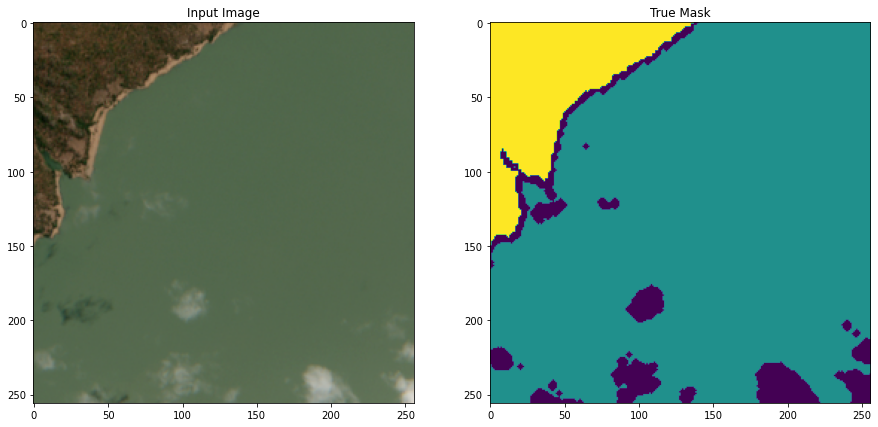

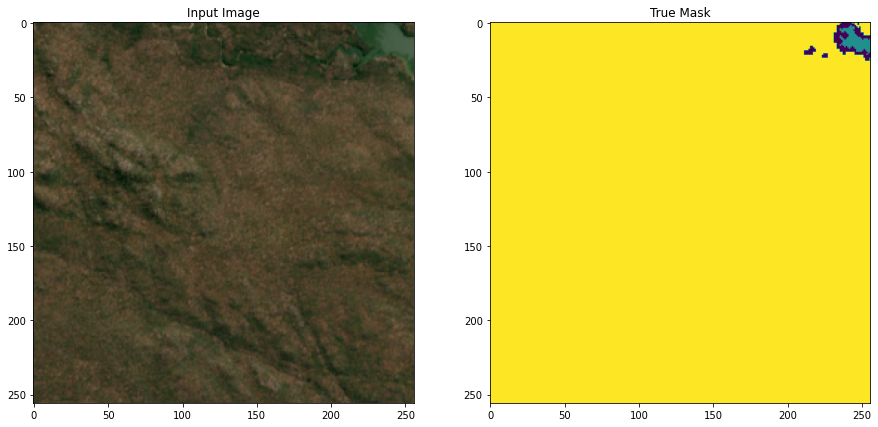

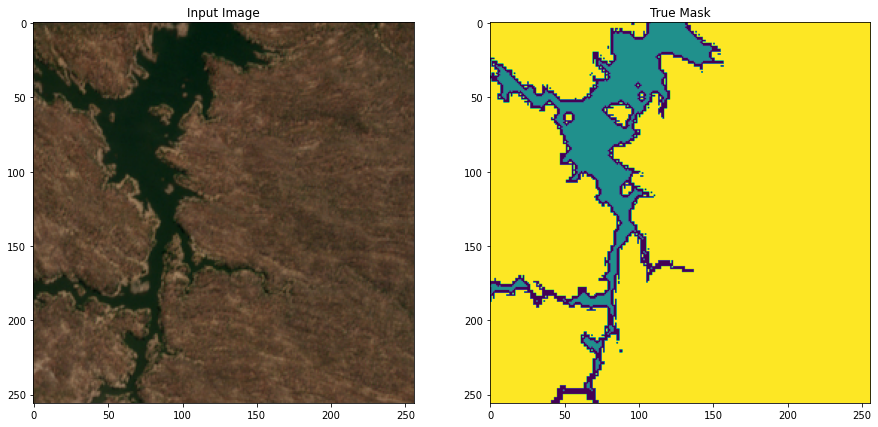

In [ ]:
train_batch_img = train_generator.getitem_as_img(10)

display(train_batch_img[0][:3], train_batch_img[1][:3])

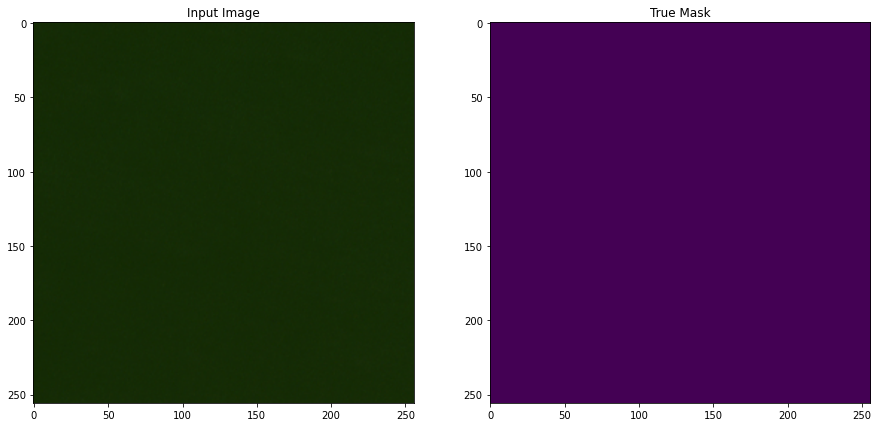

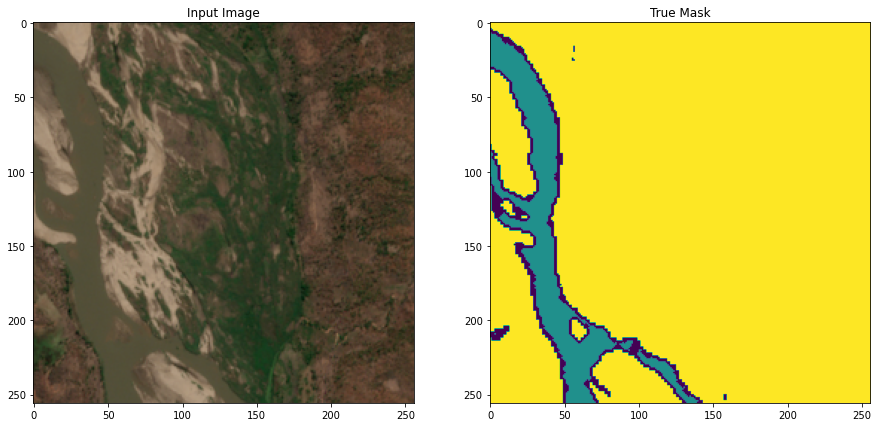

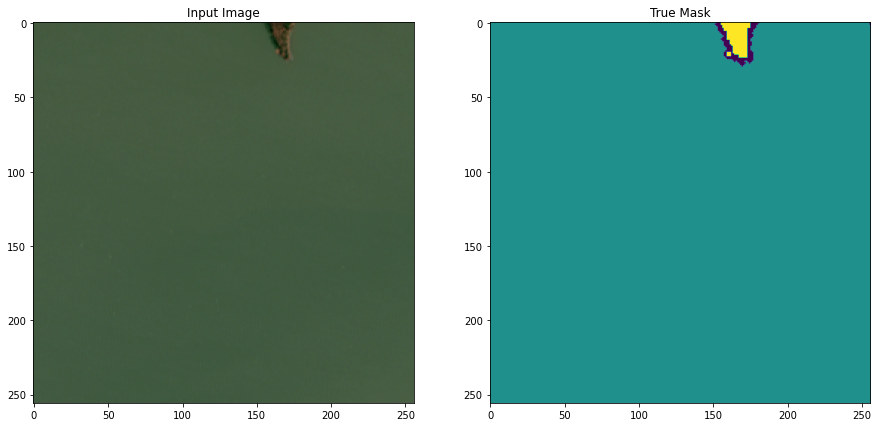

In [ ]:
val_batch_img = val_generator.getitem_as_img(2)

display(val_batch_img[0][:3], val_batch_img[1][:3])

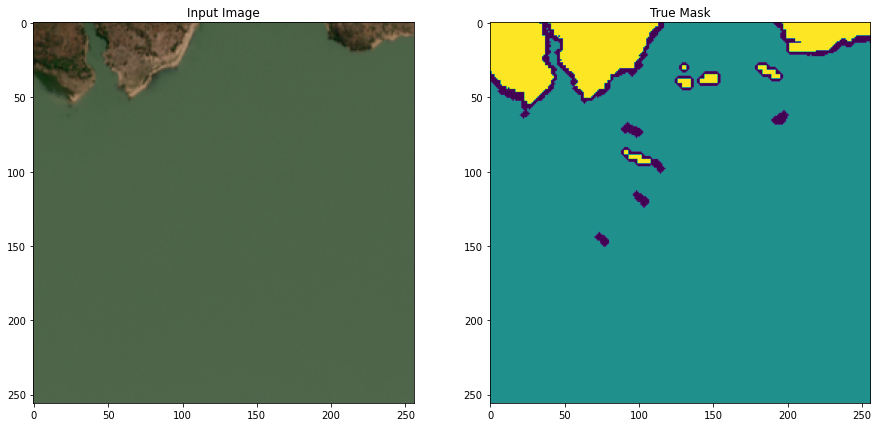

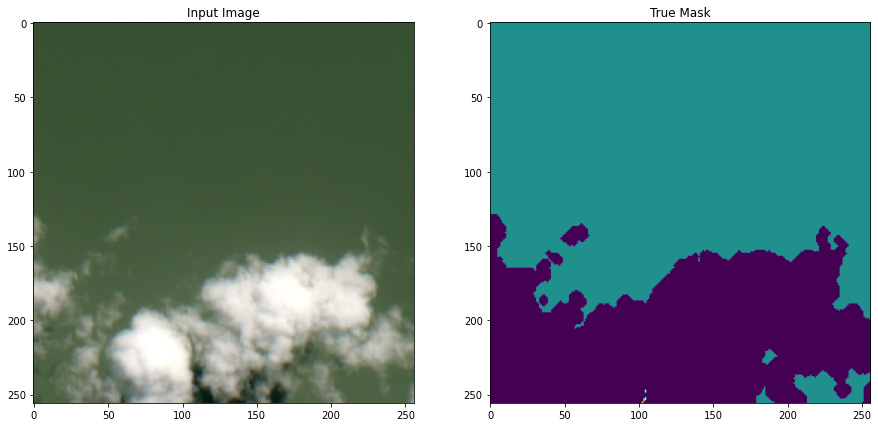

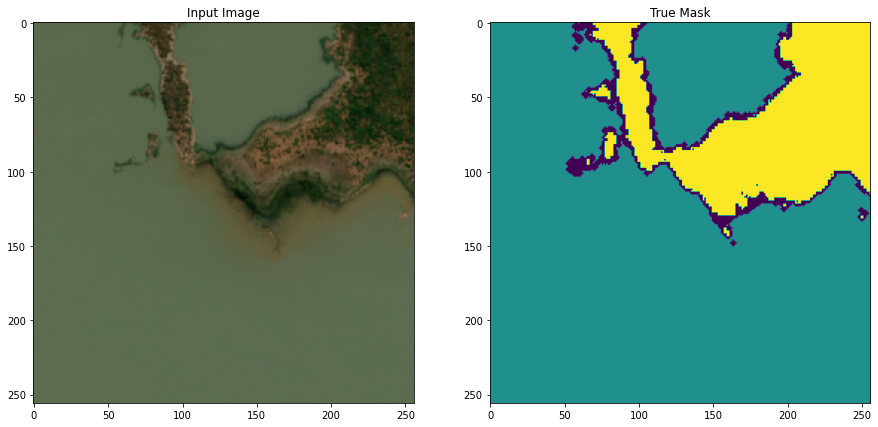

In [ ]:
test_batch_img = test_generator.getitem_as_img(4)

display(test_batch_img[0][:3], test_batch_img[1][:3])

### 3. Definint the model

In [ ]:
def unet_2d(input_shape, num_classes):

    # Define the input layer
    inputs = Input(input_shape)

    # Downsample layers
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Upsample layers
    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    # Output layer
    output = Conv2D(num_classes, (1, 1), activation='softmax')(conv7)

    # Define the model
    model = Model(inputs=[inputs], outputs=[output])

    return model

### 5. Model training

In [ ]:
tile_size = 256
step_size = 256
saving_path = 'experiment_3'


model = unet_2d(input_shape=(256, 256, 5), num_classes=3)

model.compile(optimizer='adam',
              loss=categorical_crossentropy,
              metrics=['accuracy']) # ??? alternatives
# model.summary()

early_stop = EarlyStopping(monitor='accuracy', patience=5) 

model_history = model.fit(train_generator, epochs=100, validation_data=val_generator, callbacks=[early_stop])

# saving model
model_name = f'{tile_size}_{step_size}_first_run'
model.save(f'../models/{saving_path}/model_{model_name}.h5')

# saving model history
with open(f'../models/{saving_path}/history_{model_name}.pkl', 'wb') as file_pi:
    pickle.dump(model_history.history, file_pi)

# making predictions
predictions = model.predict(test_generator)

# Todo: modify/ make subclass of EvaluationMetrics that can deal with DataGenerators as input

Epoch 1/100
16/16 [==============================] - 27s 1s/step - loss: 0.8540 - accuracy: 0.5831 - val_loss: 0.3509 - val_accuracy: 0.8684
Epoch 2/100
16/16 [==============================] - 23s 1s/step - loss: 0.3141 - accuracy: 0.8881 - val_loss: 0.2267 - val_accuracy: 0.8967
Epoch 3/100
16/16 [==============================] - 24s 1s/step - loss: 0.1502 - accuracy: 0.9537 - val_loss: 0.1035 - val_accuracy: 0.9678
Epoch 4/100
16/16 [==============================] - 23s 1s/step - loss: 0.1178 - accuracy: 0.9662 - val_loss: 0.1109 - val_accuracy: 0.9659
Epoch 5/100
16/16 [==============================] - 23s 1s/step - loss: 0.1114 - accuracy: 0.9658 - val_loss: 0.1085 - val_accuracy: 0.9594
Epoch 6/100
16/16 [==============================] - 23s 1s/step - loss: 0.0952 - accuracy: 0.9669 - val_loss: 0.0915 - val_accuracy: 0.9726
Epoch 7/100
16/16 [==============================] - 23s 1s/step - loss: 0.0836 - accuracy: 0.9705 - val_loss: 0.0727 - val_accuracy: 0.9724
Epoch 8/100
1

### 6. Training Results

In [ ]:
def plot_loss_acc(plots, y_scale):
  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']
  acc = model_history.history['accuracy']
  val_acc = model_history.history['val_accuracy']

  plt.figure(figsize=(10,6))
  if 'loss' in plots:
    plt.plot(model_history.epoch, loss, 'g', label='Training Loss')
  if 'accuracy' in plots:
    plt.plot(model_history.epoch, acc, 'y', label='Training Accuracy')
  if 'val_loss' in plots:
    plt.plot(model_history.epoch, val_loss, 'r', label='Validation Loss')
  if 'val_accuracy' in plots:
    plt.plot(model_history.epoch, val_acc, 'b', label='Validation Accuracy')
  plt.title('')
  plt.xlabel('Epoch')
  plt.ylabel('Value')
  if y_scale == 'all':
    plt.ylim([0, 1])
  elif y_scale == 'loss':
    plt.ylim([0, 25])
  else:
    plt.ylim([0.8, 1])
  plt.legend()

  plt.show()



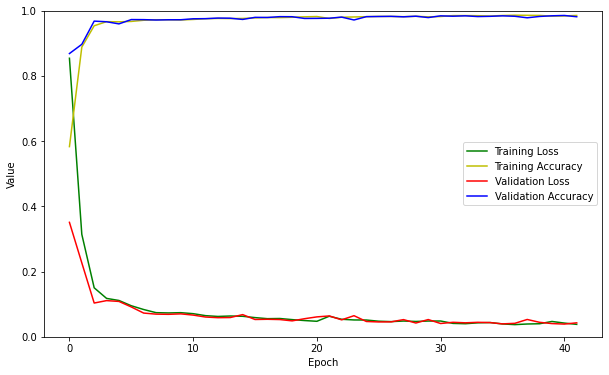

In [ ]:
plot_loss_acc(['loss', 'accuracy', 'val_loss', 'val_accuracy'], 'all') ### val_loss not showing => does not fit on scale

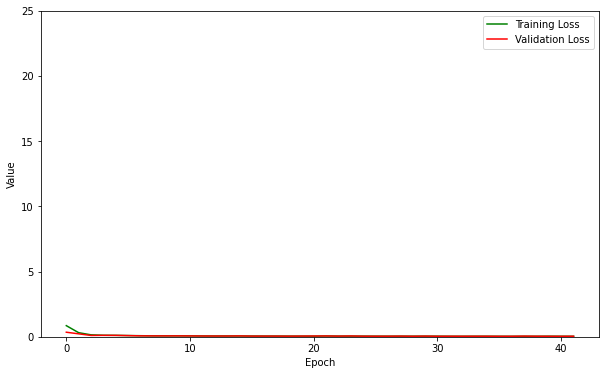

In [ ]:
plot_loss_acc(['loss', 'val_loss',], 'loss')

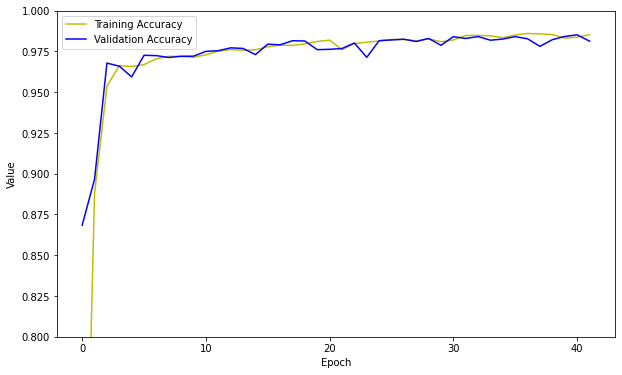

In [ ]:
plot_loss_acc(['accuracy', 'val_accuracy'], 'accuracy')